In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse
from tqdm.notebook import tqdm
import re
import post_preprocess as ppp

#from chemCPA.helper import rank_genes_groups_by_cov
#from chemCPA.paths import DATA_DIR

sc.set_figure_params(dpi=100, frameon=False)
sc.logging.print_header()
warnings.filterwarnings("ignore")

/tmp/ipykernel_13578/2340210473.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/manu/bl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 pynndescent==0.5.11


In [2]:
Path='/home/manu/chemCPA/chemCPA/anndatas'

In [3]:
# Get raw data
# These raw sciplex junks I got from chemCPA https://dl.fbaipublicfiles.com/dlp/cpa_binaries.tar

#adatas = []
#for i in range(5):
#    adatas.append(sc.read(f'{Path}/sciplex_raw_chunk_{i}.h5ad'))
#adata = adatas[0].concatenate(adatas[1:])
#adata.write(f'{Path}/sciplex.h5ad', compression='gzip')

In [4]:
adata=sc.read(f'{Path}/sciplex.h5ad')

In [5]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [6]:
def remove_non_alphanumeric(input_string):
    return re.sub(r"[^a-zA-Z0-9]", "", input_string)

## Fix adata.obs

In [7]:
#sc.pp.subsample(adata, fraction=0.1)

In [8]:
adata.obs['cell_line']=adata.obs['cell_type']

adata.obs['treatment']=[a.split(' (')[0] for a in adata.obs['product_name']]
adata.obs['treatment']=[a if a!='Vehicle' else 'control' for a in adata.obs['treatment']]
adata.obs["treatment"] = adata.obs["treatment"].apply(remove_non_alphanumeric)

adata.obs['treatment_dose_uM']=adata.obs['dose'].astype('str')

# I looked this up in the publication
adata.obs['treatment_time_h']=24.0

adata.obs['treatment_type']='drug_perturbation'

adata.obs['dataset']='Sciplex'

In [9]:
# We only need these columns
adata.obs=adata.obs[['cell_line', 'treatment', 'treatment_dose_uM', 'treatment_time_h', 'treatment_type', 'dataset']]
adata.obs

,cell_line,treatment,treatment_dose_uM,treatment_time_h,treatment_type,dataset
index,,,,,,
A01_E09_RT_BC_100_Lig_BC_245-0-0-0,A549,Enzastaurin,1000.0,24.0,drug_perturbation,Sciplex
A01_E09_RT_BC_100_Lig_BC_306-0-0-0,A549,Raltitrexed,10.0,24.0,drug_perturbation,Sciplex
A01_E09_RT_BC_101_Lig_BC_109-0-0-0,A549,control,0.0,24.0,drug_perturbation,Sciplex
A01_E09_RT_BC_101_Lig_BC_229-0-0-0,A549,Lenalidomide,10.0,24.0,drug_perturbation,Sciplex
A01_E09_RT_BC_101_Lig_BC_280-0-0-0,A549,DivalproexSodium,1000.0,24.0,drug_perturbation,Sciplex
...,...,...,...,...,...,...
H12_F10_RT_BC_99_Lig_BC_172-1-4,K562,PD173074,1000.0,24.0,drug_perturbation,Sciplex
H12_F10_RT_BC_99_Lig_BC_226-1-4,K562,Baricitinib,100.0,24.0,drug_perturbation,Sciplex
H12_F10_RT_BC_99_Lig_BC_337-1-4,K562,Entinostat,10.0,24.0,drug_perturbation,Sciplex


## Fix adata.var

In [10]:
# They have some Ensemble Id's with .?_PAR_Y in the end, where ? is the release number of the assembly
# These are X/Y-chromosomal genes that behave like any other non-sex genes.
# "From release 44 onwards, the chromosome Y PAR annotation has their own identifiers."
# I'll just sum them up, from what I can tell they are no longer treated in a different way
# (as they are de facto autosomal)

In [11]:
# For all the other genes I'll remove the version number

In [12]:
adata.var.index=adata.var['id']

adata.var['cut']=[a.split('.')[0] for a in adata.var.id]

av=adata.var['cut'].value_counts()
duplicated=list(av[av>1].index)
adata.var[adata.var['cut'].isin(duplicated)]

,id,num_cells_expressed-0-0,num_cells_expressed-1-0,num_cells_expressed-1,cut
id,,,,,
ENSG00000002586.18,ENSG00000002586.18,0,0,0,ENSG00000002586
ENSG00000002586.18_PAR_Y,ENSG00000002586.18_PAR_Y,1,4,0,ENSG00000002586
ENSG00000124333.15,ENSG00000124333.15,0,0,0,ENSG00000124333
ENSG00000124333.15_PAR_Y,ENSG00000124333.15_PAR_Y,0,1,1,ENSG00000124333
ENSG00000124334.17,ENSG00000124334.17,0,0,0,ENSG00000124334
...,...,...,...,...,...
ENSG00000277120.5_PAR_Y,ENSG00000277120.5_PAR_Y,0,0,0,ENSG00000277120
ENSG00000280767.3,ENSG00000280767.3,0,0,0,ENSG00000280767
ENSG00000280767.3_PAR_Y,ENSG00000280767.3_PAR_Y,0,0,0,ENSG00000280767


In [13]:
'''
Check/Proof that it are indeed only _Y_PAR genes:

adata.var[adata.var['cut'].isin(duplicated)]['cut'].value_counts()
np.sum([a[-5:]=='PAR_Y' for a in adata.var[adata.var['cut'].isin(duplicated)]['id']])

'''

"\nCheck/Proof that it are indeed only _Y_PAR genes:\n\nadata.var[adata.var['cut'].isin(duplicated)]['cut'].value_counts()\nnp.sum([a[-5:]=='PAR_Y' for a in adata.var[adata.var['cut'].isin(duplicated)]['id']])\n\n"

In [14]:
# This takes 2min
inds_to_remove=[]
for d in duplicated:
    inds=np.where(adata.var['cut']==d)[0]
    v=adata.X[:,inds]
    v=v[:,0]+v[:,1]
    adata.X[:,inds[0]]=v
    inds_to_remove.append(inds[1])

In [15]:
exclude=[list(adata.var.index)[a] for a in inds_to_remove]
adata = adata[:, ~adata.var_names.isin(exclude)].copy()

In [16]:
# I'll ignore the ensemble version number
adata.var.index=[a.split('.')[0] for a in adata.var.index]
for c in adata.var.columns:
    del adata.var[c]

In [17]:
D_smiles = np.load('D_smiles.npy', allow_pickle=True).item()
D_smiles['control']='CS(=O)C'
treatments=list(adata.obs['treatment'])
treatment_types=list(adata.obs['treatment_type'])

smiles=[]
for i in range(len(adata)):
    if treatment_types[i]!='drug_perturbation':
        smiles.append('')
    else:
        smiles.append(D_smiles.get(treatments[i], ''))
adata.obs['SMILES']=smiles

In [18]:
# Smiles embedding:
dfp=pd.read_parquet('/home/manu/chemCPA/test/rdkit2D_embedding.parquet')
smiles_kept=list(dfp.index)

In [19]:
(adata.obs['SMILES'].isin(smiles_kept)).sum()

581777

In [21]:
adata=adata[adata.obs['SMILES'].isin(smiles_kept)].copy()

In [22]:
# This calls DEGs and filters out treatments with to little cells
adata=ppp.postprocess_anndata(adata, n_top_genes=2000)

A549
MCF7
K562


In [23]:
# It writes/reads faster when not using compression
adata.write(f'{Path}/Sciplex_pp.h5ad')

In [24]:
# It writes/reads faster when not using compression
adata.write(f'{Path}/Sciplex_pp_sub.h5ad')

In [28]:
adata.obs[adata.obs['split']=='ood']['treatment'].value_counts().sum()

97663

In [29]:
adata.obs['treatment'].value_counts().sum()

581777

# Exploration

In [4]:
import anndata
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
Path='/home/manu/chemCPA/chemCPA'

In [5]:
adata=sc.read(f'{Path}/Sciplex_pp.h5ad')

/home/manu/bl/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
a0=adata[adata.obs['treatment'].isin(['control'])].copy()
a1=adata[adata.obs['treatment'].isin(['Mocetinostat', 'Entinostat', 'Givinostat', 'Patupilone'])].copy()
#a1=adata[adata.obs['treatment'].isin(['Dasatinib'])].copy()

In [7]:
sc.pp.subsample(a0, fraction=0.25)

In [8]:
ac=a0.concatenate(a1)

/tmp/ipykernel_11465/3252360331.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ac=a0.concatenate(a1)


In [9]:
ac=ac[ac.obs['cell_line']=='A549'].copy()

In [10]:
sc.pp.neighbors(ac)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/manu/bl/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/manu/bl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
sc.tl.umap(ac)

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(3,3)})
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300

/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


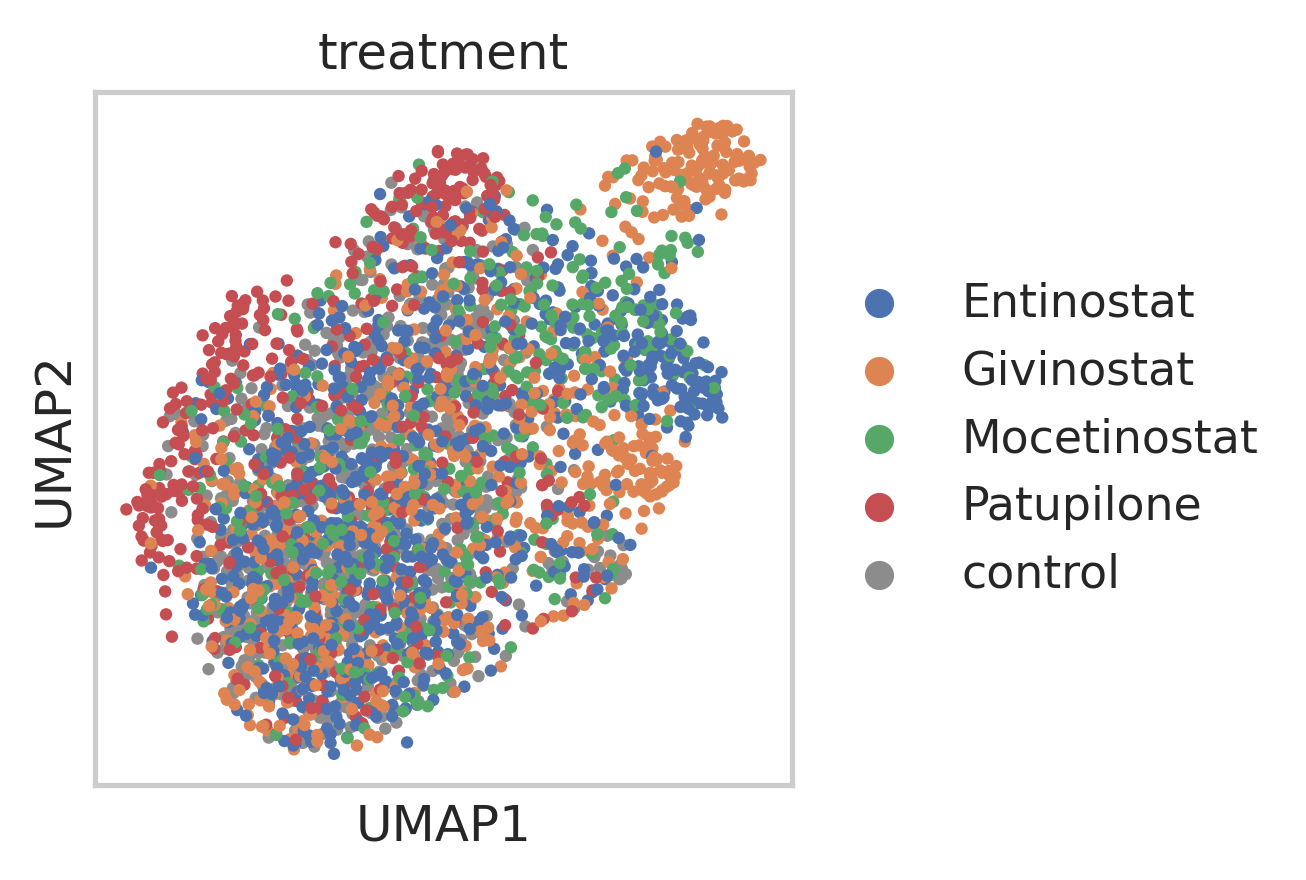

In [13]:
sc.pl.umap(ac, color='treatment', palette=list(sns.color_palette())[:4]+list(sns.color_palette())[7:8])

/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


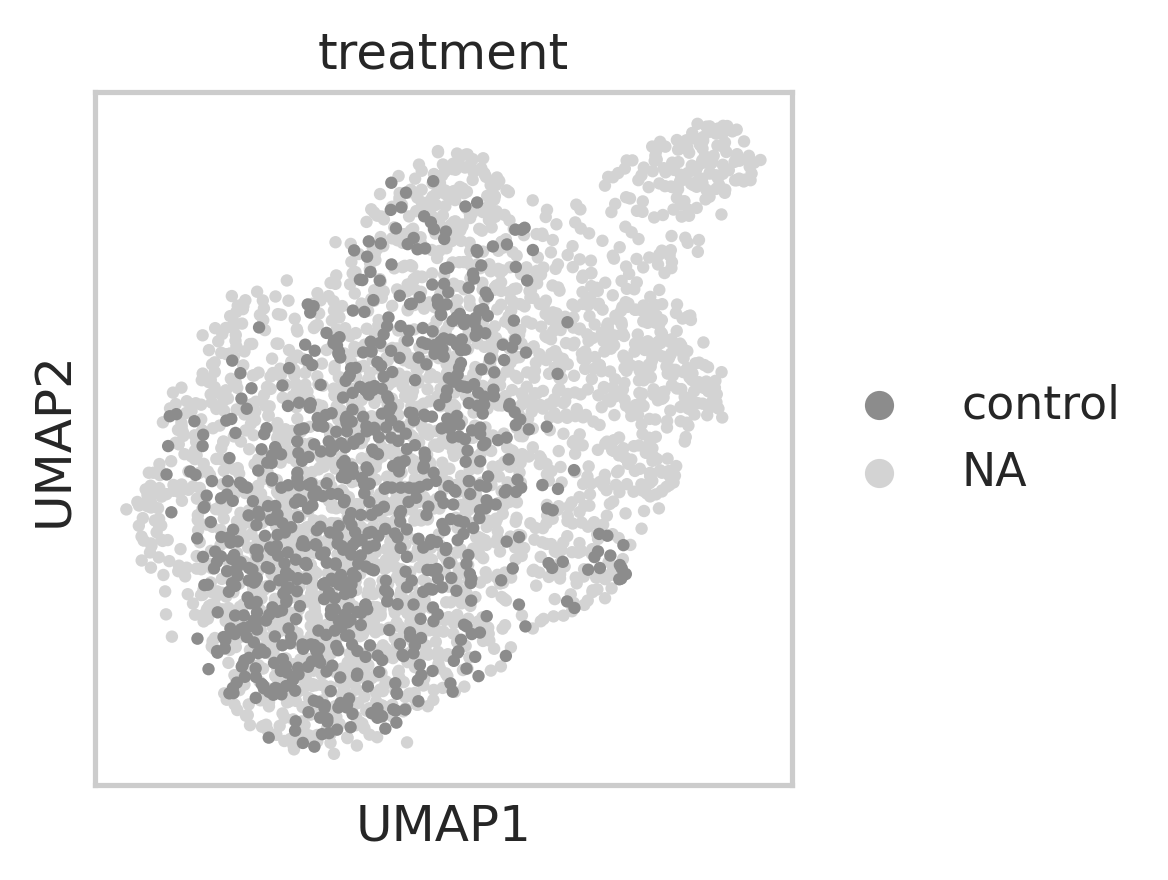

In [14]:
sc.pl.umap(ac, color='treatment', groups=['control'])